In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [11]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [14]:
df = pd.read_csv('extracted_24k.csv')

In [15]:
df = df.drop(columns=['Unnamed: 0','url','comments','num_comments','created','subreddit_y','post_id'])
df.head()

title  score      id subreddit_x  \
0                        Community Comments     22  dztn6a  Capitalism   
1                        Community Comments     22  dztn6a  Capitalism   
2                        Community Comments     22  dztn6a  Capitalism   
3                        Community Comments     22  dztn6a  Capitalism   
4  Ranking US Occupations by Wage 1999-2018     31  e4iwb0  Capitalism   

                                             comment  
0                                          [deleted]  
1  Hey, if you need mods i am willing to be one. ...  
2  I have tagged several posts as the spam that t...  
3  laissez-faire moderating: usually better than ...  
4  A good version of this would be a normalized v...

In [22]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
stops = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
def clean(s):
    s = s.lower()
    s_token = tokenizer.tokenize(s)
    s_filtered = [w for w in s_token if not w in stops]
    return s_filtered

In [23]:
df['comment_tokenized'] = df['comment'].apply(clean)

In [24]:
from collections import Counter

def get_counts(s):
    return Counter(s)

In [26]:
president_counts = {'warren':0, 'biden':0, 'sanders':0, 'buttigieg':0, 'yang':0, 'trump':0}
issue_counts = {'guns':0, 'wealth':0, 'immigration':0, 'foreign':0, 'weed':0, 
                'climate':0, 'tech':0, 'jobs':0, 'economy':0, 'nationalism':0, 'china':0, 'healthcare':0}
def count_attributes(s):
    for key in s.keys():
        if key in president_counts:
            president_counts[key] += 1
        if key in issue_counts:
            issue_counts[key] += 1

In [27]:
df['word_counts'].apply(count_attributes)
print(president_counts)

{'warren': 554, 'biden': 659, 'sanders': 363, 'buttigieg': 204, 'yang': 504, 'trump': 2221}


In [28]:
df['word_counts'].apply(count_attributes)
print(issue_counts)

{'guns': 212, 'wealth': 436, 'immigration': 174, 'foreign': 480, 'weed': 64, 'climate': 602, 'tech': 104, 'jobs': 310, 'economy': 476, 'nationalism': 40, 'china': 488}


In [29]:
presidents = sorted(president_counts, key=president_counts.get, reverse=True)
presidents_num = sorted(np.fromiter(president_counts.values(), dtype=float), reverse=True)

In [30]:
candidates_df = pd.DataFrame({'Candidate': presidents, 'Frequency': presidents_num})
candidates_df

Candidate  Frequency
0      trump     4442.0
1      biden     1318.0
2     warren     1108.0
3       yang     1008.0
4    sanders      726.0
5  buttigieg      408.0

In [34]:
candidate_comentions = np.zeros((6, 6))

def count_comentions(s):
    for i in range(6):
        for j in range(6):
            if presidents[i] in s.keys() and presidents[j] in s.keys():
                candidate_comentions[i][j]+=1
                
temp = df['word_counts'].apply(count_comentions)

In [37]:
candidate_comentions
df_candidate_comentions = pd.DataFrame(candidate_comentions, columns=presidents, index=presidents)
df_candidate_comentions

trump  biden  warren   yang  sanders  buttigieg
trump      2221.0  183.0   108.0   51.0     80.0       38.0
biden       183.0  659.0   174.0   55.0     96.0       76.0
warren      108.0  174.0   554.0   73.0    177.0       83.0
yang         51.0   55.0    73.0  504.0     42.0       28.0
sanders      80.0   96.0   177.0   42.0    363.0       63.0
buttigieg    38.0   76.0    83.0   28.0     63.0      204.0

In [38]:
lifts = np.zeros((6, 6))
N = len(df)
for i in range(6):
    count1 = presidents_num[i]
    for j in range(6):
        count2 = presidents_num[j]
        denom = count1 * count2
        numer = candidate_comentions[i][j]
        lifts[i][j] = (numer/denom) * N
np.set_printoptions(precision = 1)
df_lifts = pd.DataFrame(lifts, columns=presidents, index=presidents)
df_lifts

trump     biden     warren       yang    sanders  buttigieg
trump      2.748086  0.763126   0.535728   0.278080   0.605639   0.511898
biden      0.763126  9.261760   2.908928   1.010708   2.449391   3.450460
warren     0.535728  2.908928  11.017148   1.595738   5.371998   4.482467
yang       0.278080  1.010708   1.595738  12.110119   1.401171   1.662173
sanders    0.605639  2.449391   5.371998   1.401171  16.814050   5.192574
buttigieg  0.511898  3.450460   4.482467   1.662173   5.192574  29.919118

# Make MDS Plot

In [39]:
dissimilarity = lifts
for i in range(6):
    for j in range(6):
        if i == j:
            dissimilarity[i][j]=0
        else:
            dissimilarity[i][j] = 1/lifts[i][j]
        
df_dissimilarity = pd.DataFrame(dissimilarity, columns=presidents, index=presidents)
df_dissimilarity

trump     biden    warren      yang   sanders  buttigieg
trump      0.000000  1.310400  1.866619  3.596085  1.651149   1.953512
biden      1.310400  0.000000  0.343769  0.989405  0.408265   0.289816
warren     1.866619  0.343769  0.000000  0.626669  0.186150   0.223091
yang       3.596085  0.989405  0.626669  0.000000  0.713689   0.601622
sanders    1.651149  0.408265  0.186150  0.713689  0.000000   0.192583
buttigieg  1.953512  0.289816  0.223091  0.601622  0.192583   0.000000

<Figure size 640x640 with 0 Axes>

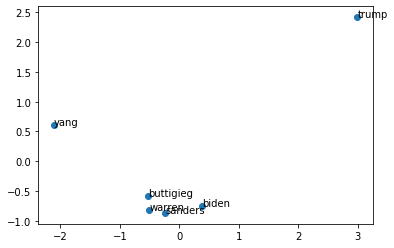

<Figure size 720x720 with 0 Axes>

In [43]:
from sklearn.manifold import MDS
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
mds = MDS(dissimilarity='euclidean')
coords = mds.fit_transform(dissimilarity)

x,y = coords.T

fig, ax=plt.subplots()
plt.figure(figsize=(10,10))
ax.scatter(x,y)

for i, txt in enumerate(presidents):
    ax.annotate(txt, (x[i],y[i]))

# Task C Type Shit

In [47]:
from itertools import chain
pd.set_option('display.max_rows', None)
all_words = pd.Series(chain(*list(df['word_counts'])))
word_frequency = all_words.value_counts()
word_frequency

people                                                                                                                                              3306
like                                                                                                                                                3282
would                                                                                                                                               2631
trump                                                                                                                                               2221
one                                                                                                                                                 2173
think                                                                                                                                               2157
https                                                                             

In [50]:
from nltk import ngrams
from nltk.tokenize import MWETokenizer
import re
tokenizer2 = MWETokenizer(r'\w+')

tuples = [('gun','control'), ('school','shooting'), ('second','amendment'), ('gun','buyback'), ('assult','rifle'), # guns
          ('universal','basic','income'), ('income','disparity'), ('glass','ceiling'), ('wage','gap'), # wealth gap
          ('illegal','alien'), ('border','control'), ('border','security'), # immigration
          ('global','policy'), # foreign policy
          ('global','warming'), ('global','cooling'), ('paris','agreement'), # climate crisis
          ('stock','market'), ('trade','deals'), ('trade','deal'), ('trade','war'), ('stock','prices'), # economy
          ('make','america','great','again'), ('keep','america','great'), ('america','first'), # nationalism
          ('medicare','for','all'), ('socialized','medicine'), ('expand', 'medicaid'), ('single','payer'), ('insurance','companies') # healthcare
          ]

for tup in tuples:
    tokenizer2.add_mwe(tup)
    
def clean_no_stop(s):
    s = s.lower()
    s = re.sub(r'[^\w\s\d]', '', s)
    s_token = tokenizer2.tokenize(s.split())
    return s_token

df['token_no_stop']=df['comment'].apply(clean_no_stop)

In [54]:
gun_phrases = ['firearm','firearms','gat','heater','ak','ak47','ak-47','ar','ar15','ar-15','shooting','shooter','gun_control', 'second_amendment', 'gun_buyback', 'assault_rifle']
wealth_phrases = ['bourgeoisie', 'poor', 'billionaire', 'billionaires', 'wealthy', 'rich', 'universal_basic_income', 'income_disparity', 'glass_ceiling', 'wage_gap']
immigration_phrases = ['immigrants', 'immigrant', 'refugee', 'refugees', 'wall','illegal_alien','border_security','border_control']
foreign_phrases = ['global_policy', 'globalization', 'allies','ally', 'nato', 'un']
weed_phrases = ['marijuana', 'pot']
climate_phrases = ['weather', 'carbon','global_warming', 'global_cooling', 'paris_agreement']
tech_phrases = ['facebook', 'amazon', 'google']
economy_phrases = ['inflation', 'fiscal', 'currency', 'dollar', 'debt', 'deficit', 'stock_market', 'trade_deal', 'trade_deals', 'trade_war', 'stock_prices', 'unemployment']
nationalism_phrases = ['maga', 'kag','make_america_great_again', 'keep_america_great', 'america_first']
healthcare_phrases = ['doctors', 'health', 'medicine', 'medical', 'medicare_for_all', 'socialized_medicine', 'expand_medicaid', 'single_payer', 'insurance_companies']

def grams_to_words(s):
    for i in range(len(s)):
        if s[i] in gun_phrases:
            s[i] = 'gun'
        elif s[i] in wealth_phrases:
            s[i] = 'wealth'
        elif s[i] in immigration_phrases:
            s[i] = 'immigration'
        elif s[i] in foreign_phrases:
            s[i] = 'foreign'
        elif s[i] in weed_phrases:
            s[i] = 'weed'
        elif s[i] in climate_phrases:
            s[i] = 'climate'
        elif s[i] in tech_phrases:
            s[i] = 'tech'
        elif s[i] in economy_phrases:
            s[i] = 'economy'
        elif s[i] in nationalism_phrases:
            s[i] = 'nationalism'
        elif s[i] in healthcare_phrases:
            s[i] = 'healthcare'
    return s

In [55]:
df['token_no_stop'] = df['token_no_stop'].apply(grams_to_words)

In [56]:
df['word_counts_v2'] = df['token_no_stop'].apply(get_counts)

In [57]:
president_counts = {'warren':0, 'biden':0, 'sanders':0, 'buttigieg':0, 'yang':0, 'trump':0}
issue_counts = {'guns':0, 'wealth':0, 'immigration':0, 'foreign':0, 'weed':0, 
                'climate':0, 'tech':0, 'jobs':0, 'economy':0, 'nationalism':0, 'china':0, 'healthcare':0}
def count_attributes(s):
    for key in s.keys():
        if key in president_counts:
            president_counts[key] += 1
        if key in issue_counts:
            issue_counts[key] += 1

In [58]:
df['word_counts_v2'].apply(count_attributes)
print(president_counts)

{'warren': 491, 'biden': 584, 'sanders': 316, 'buttigieg': 181, 'yang': 460, 'trump': 2024}


In [59]:
df['word_counts'].apply(count_attributes)
print(issue_counts)

{'guns': 210, 'wealth': 1113, 'immigration': 367, 'foreign': 591, 'weed': 112, 'climate': 659, 'tech': 262, 'jobs': 308, 'economy': 672, 'nationalism': 83, 'china': 473, 'healthcare': 751}


In [62]:
issues = sorted(issue_counts, key=issue_counts.get, reverse=True)
issues_num = sorted(np.fromiter(issue_counts.values(), dtype=float), reverse=True)

In [64]:
issues_df = pd.DataFrame({'Candidate/Issue': issues, 'Frequency': issues_num})
issues_df

Candidate/Issue  Frequency
0           wealth     1113.0
1       healthcare      751.0
2          economy      672.0
3          climate      659.0
4          foreign      591.0
5            china      473.0
6      immigration      367.0
7             jobs      308.0
8             tech      262.0
9             guns      210.0
10            weed      112.0
11     nationalism       83.0

In [65]:
candidates_issues = presidents + issues
candidates_issues_num = presidents_num + issues_num
print(candidates_issues_num)

[4442.0, 1318.0, 1108.0, 1008.0, 726.0, 408.0, 1113.0, 751.0, 672.0, 659.0, 591.0, 473.0, 367.0, 308.0, 262.0, 210.0, 112.0, 83.0]


In [67]:
candidates_issues_comentions = np.zeros((18,18))

def count_comentions_v2(s):
    for i in range(18):
        for j in range(18):
            if candidates_issues[i] in s.keys() and candidates_issues[j] in s.keys():
                candidates_issues_comentions[i][j]+=1
trash = df['word_counts_v2'].apply(count_comentions_v2)

In [68]:
df_candidates_issues_comentions = pd.DataFrame(candidates_issues_comentions, columns=candidates_issues, index=candidates_issues)

In [69]:
df_candidates_issues_comentions

trump  biden  warren   yang  sanders  buttigieg  wealth  \
trump        2024.0  155.0    90.0   44.0     61.0       33.0   100.0   
biden         155.0  584.0   150.0   45.0     80.0       63.0    41.0   
warren         90.0  150.0   491.0   62.0    148.0       71.0    69.0   
yang           44.0   45.0    62.0  460.0     37.0       23.0    28.0   
sanders        61.0   80.0   148.0   37.0    316.0       53.0    40.0   
buttigieg      33.0   63.0    71.0   23.0     53.0      181.0    17.0   
wealth        100.0   41.0    69.0   28.0     40.0       17.0   895.0   
healthcare     72.0   30.0    52.0   25.0     41.0       21.0    84.0   
economy        57.0   19.0    31.0   14.0     21.0        7.0    97.0   
climate        52.0   13.0    13.0    7.0     13.0        6.0    38.0   
foreign        90.0   26.0    10.0    8.0      9.0        9.0    16.0   
china          31.0    7.0     5.0    3.0      3.0        0.0    18.0   
immigration    50.0   12.0    17.0   10.0     17.0        6.0    31.0   
jobs           27.0    6.0     7.0   12.0      3.0        2.0    28.0   
tech           20.0    7.0    14.0   11.0      9.0        2.0    24.0   
guns           16.0    6.0     5.0    5.0      1.0        5.0     9.0   
weed           10.0    7.0     4.0    3.0      2.0        0.0     8.0   
nationalism    15.0    1.0     0.0    0.0      1.0        1.0     5.0   

             healthcare  economy  climate  foreign  china  immigration   jobs  \
trump              72.0     57.0     52.0     90.0   31.0         50.0   27.0   
biden              30.0     19.0     13.0     26.0    7.0         12.0    6.0   
warren             52.0     31.0     13.0     10.0    5.0         17.0    7.0   
yang               25.0     14.0      7.0      8.0    3.0         10.0   12.0   
sanders            41.0     21.0     13.0      9.0    3.0         17.0    3.0   
buttigieg          21.0      7.0      6.0      9.0    0.0          6.0    2.0   
wealth             84.0     97.0     38.0     16.0   18.0         31.0   28.0   
healthcare        550.0     60.0     33.0     14.0    5.0         17.0   26.0   
economy            60.0    434.0     36.0     27.0   32.0         27.0   40.0   
climate            33.0     36.0    358.0     16.0   23.0         17.0   10.0   
foreign            14.0     27.0     16.0    351.0   29.0         10.0    7.0   
china               5.0     32.0     23.0     29.0  229.0         12.0   10.0   
immigration        17.0     27.0     17.0     10.0   12.0        280.0   14.0   
jobs               26.0     40.0     10.0      7.0   10.0         14.0  153.0   
tech               18.0     14.0      9.0      3.0    7.0         11.0   10.0   
guns                3.0      5.0      2.0      6.0    1.0          8.0    1.0   
weed               10.0      4.0      4.0      1.0    3.0          4.0    1.0   
nationalism         0.0      4.0      1.0      4.0    2.0          2.0    0.0   

              tech   guns  weed  nationalism  
trump         20.0   16.0  10.0         15.0  
biden          7.0    6.0   7.0          1.0  
warren        14.0    5.0   4.0          0.0  
yang          11.0    5.0   3.0          0.0  
sanders        9.0    1.0   2.0          1.0  
buttigieg      2.0    5.0   0.0          1.0  
wealth        24.0    9.0   8.0          5.0  
healthcare    18.0    3.0  10.0          0.0  
economy       14.0    5.0   4.0          4.0  
climate        9.0    2.0   4.0          1.0  
foreign        3.0    6.0   1.0          4.0  
china          7.0    1.0   3.0          2.0  
immigration   11.0    8.0   4.0          2.0  
jobs          10.0    1.0   1.0          0.0  
tech         210.0    3.0   2.0          0.0  
guns           3.0  104.0   1.0          0.0  
weed           2.0    1.0  80.0          0.0  
nationalism    0.0    0.0   0.0         63.0

In [72]:
issue_lifts = np.zeros((18, 18))
N = len(df)
for i in range(18):
    count1 = candidates_issues_num[i]
    for j in range(18):
        count2 = candidates_issues_num[j]
        denom = count1 * count2
        numer = candidates_issues_comentions[i][j]
        issue_lifts[i][j] = (numer/denom) * N
np.set_printoptions(precision = 1)
df_issue_lifts = pd.DataFrame(issue_lifts, columns = candidates_issues, index = candidates_issues)
df_issue_lifts

trump     biden    warren       yang    sanders  buttigieg  \
trump        2.504335  0.646363  0.446440   0.239912   0.461800   0.444543   
biden        0.646363  8.207690  2.507697   0.826943   2.041159   2.860249   
warren       0.446440  2.507697  9.764295   1.355284   4.491840   3.834400   
yang         0.239912  0.826943  1.355284  11.052886   1.234365   1.365357   
sanders      0.461800  2.041159  4.491840   1.234365  14.637024   4.368356   
buttigieg    0.444543  2.860249  3.834400   1.365357   4.368356  26.545884   
wealth       0.493816  0.682358  1.366008   0.609314   1.208557   0.913971   
healthcare   0.526930  0.739954  1.525677   0.806266   1.835888   1.673240   
economy      0.466193  0.523730  1.016463   0.504588   1.050878   0.623315   
climate      0.433689  0.365411  0.434667   0.257271   0.663377   0.544809   
foreign      0.836981  0.814910  0.372831   0.327854   0.512103   0.911242   
china        0.360214  0.274132  0.232921   0.153617   0.213286   0.000000   
immigration  0.748797  0.605674  1.020662   0.659952   1.557705   0.978282   
jobs         0.481807  0.360848  0.500779   0.943646   0.327546   0.388560   
tech         0.419555  0.494903  1.177405   1.016880   1.155164   0.456780   
guns         0.418756  0.529243  0.524626   0.576672   0.160134   1.424720   
weed         0.490730  1.157720  0.786939   0.648756   0.600502   0.000000   
nationalism  0.993284  0.223175  0.000000   0.000000   0.405158   0.720943   

                wealth  healthcare    economy    climate    foreign  \
trump         0.493816    0.526930   0.466193   0.433689   0.836981   
biden         0.682358    0.739954   0.523730   0.365411   0.814910   
warren        1.366008    1.525677   1.016463   0.434667   0.372831   
yang          0.609314    0.806266   0.504588   0.257271   0.327854   
sanders       1.208557    1.835888   1.050878   0.663377   0.512103   
buttigieg     0.913971    1.673240   0.623315   0.544809   0.911242   
wealth       17.638906    2.453483   3.166258   1.264859   0.593849   
healthcare    2.453483   23.807937   2.902558   1.627899   0.770087   
economy       3.166258    2.902558  23.463356   1.984663   1.659763   
climate       1.264859    1.627899   1.984663  20.125707   1.002966   
foreign       0.593849    0.770087   1.659763   1.002966  24.534154   
china         0.834748    0.343643   2.457868   1.801442   2.532727   
immigration   1.852846    1.505851   2.672806   1.716075   1.125603   
jobs          1.994119    2.744237   4.718228   1.202826   0.938856   
tech          2.009341    2.233419   1.941317   1.272608   0.473011   
guns          0.940085    0.464409   0.865009   0.352829   1.180276   
weed          1.566808    2.902558   1.297513   1.323109   0.368836   
nationalism   1.321404    0.000000   1.750861   0.446350   1.990826   

                 china  immigration       jobs       tech       guns  \
trump         0.360214     0.748797   0.481807   0.419555   0.418756   
biden         0.274132     0.605674   0.360848   0.494903   0.529243   
warren        0.232921     1.020662   0.500779   1.177405   0.524626   
yang          0.153617     0.659952   0.943646   1.016880   0.576672   
sanders       0.213286     1.557705   0.327546   1.155164   0.160134   
buttigieg     0.000000     0.978282   0.388560   0.456780   1.424720   
wealth        0.834748     1.852846   1.994119   2.009341   0.940085   
healthcare    0.343643     1.505851   2.744237   2.233419   0.464409   
economy       2.457868     2.672806   4.718228   1.941317   0.865009   
climate       1.801442     1.716075   1.202826   1.272608   0.352829   
foreign       2.532727     1.125603   0.938856   0.473011   1.180276   
china        24.989188     1.687691   1.675819   1.379033   0.245787   
immigration   1.687691    50.753365   3.023780   2.792957   2.534216   
jobs          1.675819     3.023780  39.375759   3.025429   0.377458   
tech          1.379033     2.792957   3.025429  74.688829   1.331189   
guns          0.245787     2.53

In [73]:
df_issue_lifts.drop(presidents, axis=1)[:6].sort_values(by='weed', ascending=False)

wealth  healthcare   economy   climate   foreign     china  \
biden      0.682358    0.739954  0.523730  0.365411  0.814910  0.274132   
warren     1.366008    1.525677  1.016463  0.434667  0.372831  0.232921   
yang       0.609314    0.806266  0.504588  0.257271  0.327854  0.153617   
sanders    1.208557    1.835888  1.050878  0.663377  0.512103  0.213286   
trump      0.493816    0.526930  0.466193  0.433689  0.836981  0.360214   
buttigieg  0.913971    1.673240  0.623315  0.544809  0.911242  0.000000   

           immigration      jobs      tech      guns      weed  nationalism  
biden         0.605674  0.360848  0.494903  0.529243  1.157720     0.223175  
warren        1.020662  0.500779  1.177405  0.524626  0.786939     0.000000  
yang          0.659952  0.943646  1.016880  0.576672  0.648756     0.000000  
sanders       1.557705  0.327546  1.155164  0.160134  0.600502     0.405158  
trump         0.748797  0.481807  0.419555  0.418756  0.490730     0.993284  
buttigieg     0.978282  0.388560  0.456780  1.424720  0.000000     0.720943

# Make MDS Plot for Issues Comentions
come back to this

__Next Steps:__
1. Sentiment Analysis
2. Recommendation System for Voters